# Homework 1: basic iterative methods

## Full credit: due September 8, before class

## 80% credit: due October 8, before class

18 points

**Collaboration statement:**

In [1]:
%pip install numpy scipy matplotlib
import numpy as np
from numpy.linalg import norm
import scipy.sparse as sparse
from scipy.sparse import csr_matrix, diags, lil_matrix
from scipy.sparse.linalg import spsolve, eigs
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


**Problem 1 (2 points):** (After lecture 1.1) Implement a matrix-vector product from the raw compressed sparse row (CSR) data structures. (~9 LOC)

In [2]:
def csr_matvec(m, n, indptr, indices, data, v):
    """
    Args:
        m (int): number of rows
        n (int): number of columns
        indptr (list(int), length m+1): row offsets
        indices (list(int)): column indices
        data (ndarray): 1D array of real matrix values associated with indices
        v (ndarray, shape (n,)): 1D array real input vector
        
    Returns:
        ndarray, shape (m,): 1D array output vector
    """
    ### BEGIN SOLUTION
    w = np.ndarray((m,))
    for i in range(m):
        row_start = indptr[i]
        row_end = indptr[i+1]
        w[i] = 0.
        for k in range(row_start, row_end):
            j = indices[k]
            w[i] += data[k] * v[j]
    return w
    ### END SOLUTION

In [3]:
# create a random matrix
m = 200
n = 100
A = np.random.rand(m,n) * 2 - 1
A[np.abs(A) < 0.5] = 0.
A = csr_matrix(A)

# create a random vector
v = np.random.rand(n) * 2 - 1

# compute the matvec with scipy
w_scipy = A @ v

# compute the matvec with your answer
w_yours = csr_matvec(m, n, A.indptr, A.indices, A.data, v)

# assert that each entry is numerically equivalent
w_diff = w_scipy - w_yours
w_diff_norm = np.linalg.norm(w_diff, np.inf)
assert(w_diff_norm < n * np.finfo(A.dtype).eps)

**Problem 2 (2 points):** (After lecture 1.2) Look at the definition of the matrix splitting $A = D - E -F$ in Saad figure 4.1 and the definition of the _backward Gauss-Seidel_ iteration $$(D - F) x^{(k+1)} = E x^{(k)} + b.$$
Implement this iteration from the raw CSR data structures.

This can be done in one for-loop over the rows of $A$.

Remember that the Gauss-Seidel iteration was motivated by solving each equatin for one unknown in order,
so the backward Gauss-Seidel iteration should look like solving each equation for one unknown in reverse order.
Your outer for-loop should look like `for i in range(n-1, -1, -1):`.
(~13 LOC)

In [4]:
def csr_backward_gs(n, indptr, indices, data, b, x_k):
    """
    Args:
        n (int): matrix size
        indptr (list(int), length m+1): row offsets
        indices (list(int)): column indices
        data (ndarray): 1D array of real matrix values associated with indices
        b (ndarray, shape (n,)): rhs vector
        x_k (ndarrah, shape (n,)): approximate solution
        
    Returns:
        ndarray, shape (n,): next approximate solution $(D-F)^{-1}(E x^{(k)} + b)
    """
    ### BEGIN SOLUTION
    x_new = x_k.copy()
    for i in range(n-1,-1,-1): # loop backward over rows
        row_start = indptr[i]
        row_end = indptr[i+1]
        r = b[i]
        a_ii = None
        for k in range(row_start, row_end):
            j = indices[k]
            if j == i:
                a_ii = data[k]
            r -= data[k] * x_new[j]
        x_new[i] += r / a_ii
    return x_new
    ### END SOLUTION

In [5]:
# create a random matrix
def random_invertible_sparse_matrix(n, phi=0.1):
    """
    Args:
        n (int): matrix size
        phi (float): target nnz fraction
    Returns:
        csr_matrix
    """
    A = (np.random.rand(n,n) * 2 - 1) / phi
    A[np.abs(A) > 1.] = 0.
    # Add a diagonal
    A += np.diag(np.abs(A) @ np.ones(n,)+1.e-3)
    return csr_matrix(A)

A = random_invertible_sparse_matrix(100)

# Get the components
D = diags(A.diagonal())
F = -sparse.triu(A,1)
E = -sparse.tril(A,-1)

# Make a random rhs
b = np.random.rand(n) * 2 - 1
# Make a random current iterate
x_0 = np.random.rand(n) * 2 - 1

# Construct the new iterate using the formula
x_1_formula = spsolve(D - F, E @ x_0 + b)

# Construct the new iterate using your function
x_1_yours = csr_backward_gs(n, A.indptr, A.indices, A.data, b, x_0)
assert(norm(x_1_formula - x_1_yours) < norm(x_1_formula) * np.finfo(A.dtype).eps**0.5)

**Problem 3 (2 points):** (After lecture 1.2) Using matrix `A` and vectors `b` and `x_0` from the previous cell, compute 30 iterations of the backward Gauss-Seidel method and record the norms of the residuals, $g_k := \|r^{(k)} := A x^{(k)} - b\|_2$.  Plot $g_k$ on a semilogy plot with the iteration $k$ on the x-axis.

Compute the spectral radius $\rho(G)$ of the _iteration matrix $G$_ for the backward Gauss-Seidel method (see Saad 4.2.1, 4.2.2).  Add a line with slope $- \ln \rho(G)$ to your plot close to the values for $g_k$ to see if the specific convergence rate matches the general convergence rate for this choice of $b$ and $x_0$.

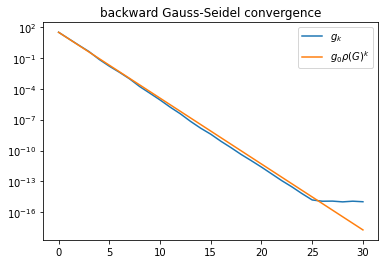

In [6]:
K = 30
g = np.ndarray((K+1,))

x_k = x_0
for i in range(K):
    g[i] = norm(b - A @ x_k)
    x_k = csr_backward_gs(n, A.indptr, A.indices, A.data, b, x_k)
g[-1] = norm(b - A @ x_k)

G = spsolve(D-F, E.toarray())
rho = np.abs(np.linalg.eig(G)[0]).max()

fig = plt.figure()
ax = fig.gca()
ax.set(title="backward Gauss-Seidel convergence")
ax.semilogy(g, label="$g_k$")
ax.semilogy([0, float(K)], [g[0], g[0]*rho**K], label=r'$g_0 \rho(G)^k$')
ax.legend()

### Background: finite element mass matrices

One way that finite difference and finite element methods differs is concept of "mass matrices".

Let's say we want to discretize a time dependent partial differential equation,

$$\dot u = L(u),$$

where $L$ is some differential operator: it's not important which one right now.

To compute, this problem has to be discretized in space and in time.  Often we can treat these two discretizations separately.
If we discretize only in space, we converge a time dependent PDE into a system or ordinary differential equations.  Those interested in the details can read more in Saad chapter 2, but the choice of finite differences versus finite elements results in ODEs with different flavors.

In particular, using finite differences the above PDE discretizes to

$$\dot u_h = L_h^{FD}(u_h),$$

and using finite elements it discretizes to

$$M_h u_h = L_h^{FE}(u_h),$$

where $M_h$ is a finite element mass matrix.  Roughly speaking, each coefficient $(u_h)_i$ is a associated with a "shape function" $\phi_i(x)$ on the domain of the PDE, and the mass matrix $M_h$ is defined by $L_2$-inner products of shape functions:

$$(M_h)_{i,j} = \int_\Omega \phi_i(x) \phi_j(x) dx.$$

This is a problem when using finite elements for time dependent problems, because before we can use a time discretization choice (like forward Euler or a Runge-Kutta method), we have to disentangle the time derivative $\dot u_h$ to put the ODE in canonical form,

$$\dot u_h = M_h^{-1} L_h^{FE}(u_h).$$

How big of a problem is this?  Can we use basic iterative methods to solve linear systems in $M_h$?  In the activity we did with lecture 1.2, we saw that the convergence rate of basic iterative methods to solve the 1D finite difference Laplacian got worse as the number of unknowns $n$ got bigger.  We might worry that the same is true of mass matrix, but the next problem will show (at least in 1D) that this is not the case.

**Problem 4 (2 points):** (After lecture 1.3) The 1D finite element mass matrix using $n+1$ uniform, piecewise linear finite elements is the tridiagonal matrix

$$M_h = \frac{1}{n+1}\begin{bmatrix}2/3 & 1/6 &  & & \\
1/6 & 2/3 & 1/6 & & \\
 & \ddots & \ddots & \ddots & \\
 & & 1/6 & 2/3 & 1/6 \\
 & & & 1/6 & 2/3
\end{bmatrix} \in \mathbb{R}^{n \times n}.$$

Let $G_J$ be the associated Jacobi iteration matrix. Prove that there is an upper bound $\rho_\max$ such that
the spectral radius $\rho(G_J) < \rho_\max < 1$ for all $n$.

Hint: you can compute $\rho(G_J)$ for a few values of $n$ to get a sense of what $\rho_\max$ should be, but you can also use the following fact that comes from Saad P-4.1: the eigenvalues of the tridiagonal matrix

$$K_h = \begin{bmatrix}2 & -1 &  & & \\
-1 & 2 & -1 & & \\
 & \ddots & \ddots & \ddots & \\
 & & -1 & 2 & -1 \\
 & & & -1 & 2
\end{bmatrix} \in \mathbb{R}^{n \times n}$$

are

$$\lambda_k = 2(1 - \cos(k \pi / (n + 1))), \quad k = 1, \dots, n.$$

These are both triadiagonal matrices with constant diagonals, which means that there exist constants $\alpha$ and $\beta$ such that $M_h = \alpha I + \beta K_h.$  That should tell you what the eigenvalues of $M_h$ are, which should in turn tell you what the eigenvalues of $G_J$ are.

The constant scaling of a matrix doesn't affect the convergence of basic iterative methods, and each $M_h$ is a constant scaling of


$$
\tilde{M}_h = \begin{bmatrix}4 & 1 &  & & \\
1 & 4 & 1 & & \\
 & \ddots & \ddots & \ddots & \\
 & & 1 & 4 & 1 \\
 & & & 1 & 4
\end{bmatrix}.
$$

$\tilde{M}_h = 6 I - K_h$, which means that its eigenvalues are

$$\mu_k = 6 - 2(1 - \cos(k \pi / (n + 1))) = 4 + 2 \cos(k \pi / (n + 1)).$$

The iteration matrix $G_J = I - \mathrm{diag}(\tilde{M}_h)^{-1} \tilde{M_h} = I - \tfrac{1}{4}\tilde{M}_h,$
which means that the eigenvalues of $G_J$ are

$$\nu_k = 1 - \tfrac{1}{4} \mu_k = \tfrac{1}{2} \cos(k \pi / (n + 1)).$$

Therefore $\rho(G_J) = \max_k |\nu_k| \leq \tfrac{1}{2}.$

Several questions and activities so far have focused on the convergence rates of basic iteratives methods for 1D discretizations of PDEs.  But on the first day we saw that direct methods are very fast for 1D problems: we're most interested in iterative methods for 2D and 3D problems.

How does increasing the dimension of a PDE affect the convergence rate of basic iterative methods?

**Problem 5 (2 points):** (After lecture 1.3) Let $L_h^{\text{1D}}$ be the 1D finite difference Laplacian with $n$ unknowns that we have seen before.  One can show that the 2D finite difference Laplacian $L_h^{\text{2D}}$ on an $n \times n$ grid with $N = n^2$ unknowns is related to $L_h^{\text{1D}}$ through the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product):

$$L_h^{\text{2D}} = L_h^{\text{1D}} \otimes I + I \otimes L_h^{\text{1D}}.$$

Let $G_J^{\text{1D}}$ be the Jacobi iteration matrix of $L_h^{\text{1D}}$ and let $G_J^{\text{2D}}$ be the Jacobi iteration matrix of $L_h^{\text{2D}}$.  Prove that

$$\rho(G_J^{\text{2D}}) = \rho(G_J^{\text{1D}}).$$

(Note that $G_J^{\text{2D}}\in \mathbb{R}^{N \times N}$ is a bigger matrix than $G_J^{\text{1D}} \in \mathbb{R}^{n \times n}$.)

Hint: here are some useful facts about Kronecker product matrices you can use:

1. $(A \otimes B)(C \otimes D) = (AC) \otimes (BD)$
2. $\alpha (A \otimes B) = (\alpha A) \otimes B = A \otimes (\alpha B)$
3. $A \otimes (B + C) = (A \otimes B) + (A \otimes C)$
4. $(A + B) \otimes C = (A \times C) + (B \otimes C)$
5. $\mathrm{diag}(A \otimes B) = \mathrm{diag}(A) \otimes \mathrm{diag}(B)$

Because $L_h^{\text{1D}}$ has a constant diagonal of $2 / h^2$,

$$G_J^{\text{1D}} = I - \frac{h^2}{2} L_h^{\text{1D}}.$$

By definition,

$$
\begin{aligned}
G_J^{\text{2D}} &= I - \mathrm{diag}(L_h^{\text{1D}} \otimes I + I \otimes L_h^{\text{1D}})^{-1}(L_h^{\text{1D}} \otimes I + I \otimes L_h^{\text{1D}}), \\
&= I - (\mathrm{diag}(L_h^{\text{1D}}) \otimes I + I \otimes \mathrm{diag}(L_h^{\text{1D}}))^{-1}(L_h^{\text{1D}} \otimes I + I \otimes L_h^{\text{1D}}) \\
&= I - ((2 / h^2) I+ (2 / h^2) I)^{-1}(L_h^{\text{1D}} \otimes I + I \otimes L_h^{\text{1D}}) \\
&= \frac{1}{2}(I - \frac{h^2}{2}(L_h^{\text{1D}} \otimes I)) + \frac{1}{2}(I - \frac{h^2}{2}(I \otimes L_h^{\text{1D}})) \\
&= \frac{1}{2}(I - \frac{h^2}{2}L_h^{\text{1D}}) \otimes I + \frac{1}{2} I \otimes (I - \frac{h^2}{2} L_h^{\text{1D}}) \\
&= \frac{1}{2} (G_J^{\text{1D}} \otimes I + I \otimes G_J^{\text{1D}}).
\end{aligned}
$$

Let $(\lambda_i, v_i)$ and $(\lambda_j, v_j)$ be any two eigenpairs of $G_J^{\text{1D}}$: then

$$\begin{aligned}
\frac{1}{2} (G_J^{\text{1D}} \otimes I + I \otimes G_J^{\text{1D}})(v_i \otimes v_j)
& =
\frac{1}{2} ((G_J^{\text{1D}} v_i) \otimes v_j + v_i \otimes (G_J^{\text{1D}} v_j)) \\
&= \frac{1}{2}((\lambda_j v_i) \otimes v_j + v_i \otimes (\lambda_j v_j)) \\
&= \frac{1}{2}(\lambda_i + \lambda_j) (v_i \otimes v_j).
\end{aligned}$$

Therefore every eigenvalue of $G_J^{\text{2D}}$ is of the form $\frac{1}{2}(\lambda_i + \lambda_j)$, and so $G_J^{\text{2D}}$ has the same spectral radius as $G_J^{\text{1D}}$.

**Problem 6 (2 points):** (After lecture 1.4) For the 1D finite difference Laplacian, compute $\rho(G_{\omega})$, the spectral radius of the SOR iteration matrix with the optimal choice of $\omega$. (~3 LOC)

Hint:  Start with the fact in Saad P-4.1 that the eigenvalues of the 1D finite difference Laplacian are

$$\lambda_k = (n+1)^2\cos(k \pi / (n + 1)), \quad k = 1, \dots n.$$

1. From this compute the eigenvalues of the Jacobi iteration, and from those eigenvalues compute its spectral radius $\rho(G_J)$.

2. From Saad 4.47 compute $\omega_{\text{opt}}$.

3. You can use Saad 4.46 and 4.47 to then show that $\rho(G_{\omega}) = \omega_{\text{opt}} - 1.$

In [7]:
def optimal_sor_radius(n):
    """
    Args:
        n (int): the number of unknowns in $L_h$, the 1D finite difference Laplacian
    Returns:
        float: the spectral radius of the SOR iteration matrix with the optimal choice of omega
    """
    ### BEGIN SOLUTION
    rho_j = - np.cos(n * np.pi / (n + 1))
    omega_opt = 2. / (1. + (1. - rho_j**2)**0.5) # 4.47
    return omega_opt - 1.
    ### END SOLUTION

Here your answer is used to plot the optimal convergence rate of SOR.

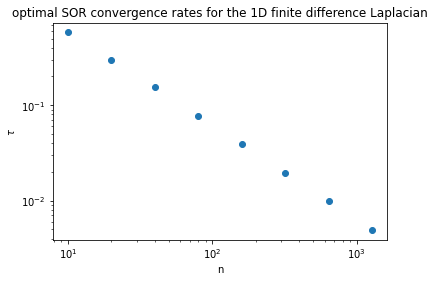

In [8]:
ns = [10, 20, 40, 80, 160, 320, 640, 1280]
radii = [optimal_sor_radius(n) for n in ns]
### BEGIN HIDDEN TESTS
def _optimal_sor_radius(n):
    rho_j = - np.cos(n * np.pi / (n + 1))
    omega_opt = 2. / (1. + (1. - rho_j**2)**0.5) # 4.47
    return omega_opt - 1.

true_radii = [_optimal_sor_radius(n) for n in ns]
assert(np.max(np.abs(np.array(true_radii) - np.array(radii))) < np.finfo('float64').eps**0.5)
### END HIDDEN TESTS
rates = - np.log(radii)
plt.scatter(ns, rates)
_ = plt.gca().set(title=r'optimal SOR convergence rates for the 1D finite difference Laplacian', xlabel='n', ylabel=r'$\tau$', xscale='log', yscale='log')

**Problem 7 (1 point):** Look at the plot generated by your answer above, and propose a model of the form

$$\tau \propto n^{\gamma}.$$

Then, looking at your model, complete the follwing sentence:

> "If optimal SOR is used to solve the 1D finite difference Laplacian, then every time $n$ doubles, the convergence rate..."

$\tau \propto n^{-1}$.  If optimal SOR is used to solve the 1D finite difference Laplacian, then every time $n$ doubles, the convergence rate halves.

**Problem 8 (2 points):** (After lecture 1.5) Define a function that computes a block-Jacobi iteration for block size $b$ (you may assume $b$ divides the matrix size $n$).  You can use `scipy.sparse.spsolve` to solve the subproblems.

In [9]:
def block_jacobi_iteration(A, rhs, x_k, b):
    """
    Args:
        A (csr_matrix): the system matrix
        rhs (ndarray): the right-hand side vector
        x_k (ndarray): the current approximate solution
        b (int): the block size; divides A.shape[0]
    Returns:
        ndarray: x_{k+1}, the result of one block Jacobi iteration
    """
    ### BEGIN SOLUTION
    nb = n // b
    assert (n % b == 0)
    r = rhs - A @ x_k
    x_new = x_k.copy()
    for i in range(nb):
        Aii = A[i*b:(i+1)*b,i*b:(i+1)*b]
        x_new[i*b:(i+1)*b] += spsolve(Aii, r[i*b:(i+1)*b])
    return x_new
    ### END SOLUTION

In [10]:
# Test: a block Jacobi iteration should converge in one iteration if the input is block diagonal
b = 5
k = 13
n = b * k
A = lil_matrix((n, n))
for i in range(k):
    A[i*b:(i+1)*b,i*b:(i+1)*b] = random_invertible_sparse_matrix(b)
A = csr_matrix(A)
rhs = np.random.rand(n) * 2 - 1
xk = np.random.rand(n) * 2 - 1
xnew = block_jacobi_iteration(A, rhs, xk, b)
rnew = rhs - A @ xnew
assert(np.linalg.norm(rnew) < np.finfo(A.dtype).eps**0.5)

### BEGIN HIDDEN TESTS
b = 7
k = 9
n = b * k
A = random_invertible_sparse_matrix(n)
D = lil_matrix((n, n))
for i in range(k):
    D[i*b:(i+1)*b,i*b:(i+1)*b] = A[i*b:(i+1)*b,i*b:(i+1)*b]
rhs = np.random.rand(n) * 2 - 1
xk = np.random.rand(n) * 2 - 1
r = rhs - A @ xk
xnew_sol = block_jacobi_iteration(A, rhs, xk, b)
xnew_true = xk + spsolve(D,r)
assert(norm(xnew_sol - xnew_true) < norm(xnew_true) * np.finfo(A.dtype).eps**0.5)
### END HIDDEN TESTS


/home/tisaac/.local/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


Here a power iteration method is used to estimate the spectral radius $\rho(G_b)$ of your block Jacobi iteration matrix applied to the 1D finite difference Laplacian for fixed $n$ and different choices of the block size $b$.  The corresponding convergence rates are plotted.

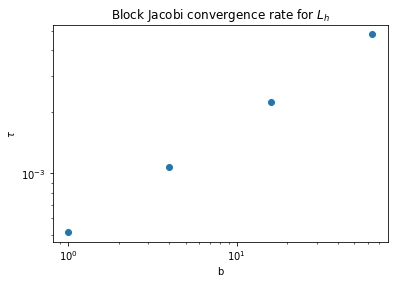

In [11]:
K = 4
n = 4**K
h = 1./(n + 1.)
A = diags([-np.ones(n),2.*np.ones(n),-np.ones(n)],offsets=[-1,0,1],shape=(n,n))
A = csr_matrix(A)
xk = np.zeros(n)

def power_iteration_estimate(matvec, x0, niter):
    xk = x0.copy() / np.linalg.norm(x0)
    rho = 0
    for i in range(niter):
        xk = matvec(xk)
        xknorm = np.linalg.norm(xk)
        rho = xknorm
        xk /= xknorm
    return rho

rates = []
bs = []
for k in range(K):
    b = 4**k
    rho_est = power_iteration_estimate(lambda r: r - A @ block_jacobi_iteration(A, r, xk, b), np.ones(n), 20)
    bs.append(b)
    rates.append(-np.log(rho_est))
    
plt.scatter(bs,rates)
_ = plt.gca().set(xscale='log', yscale='log', xlabel='b', ylabel=r'$\tau$', title=r'Block Jacobi convergence rate for $L_h$')

**Problem 9 (1 points):** (After lecture 1.5) Look at the plot above relating block size $b$ to convergence rate $\tau$ and propose a model of the form

$$\tau \propto b^\gamma.$$  

Then, looking at your model, complete the following sentence:

> "Every time the block sizes $b$ decreases by a factor of 4, the convergence rate..."

$\tau \propto b^{1/2}.$  Every time the block sizes $b$ decreases by a factor of 4, the convergence rate halves.

**Problem 10 (2 points):** (After lecture 1.5) Suppose we are solving the 1D finite difference Laplacian on a parallel computer using a block-Jacobi iteration. Assuming there are $p$ processors and $p$ divides $n$, we will use a block size $b = n / p$, so that each processor exactly solves the diagonal block assigned to it.  Each diagonal block is in fact a tridiagonal matrix that can be solved in linear time.  We will model the time for one block Jacobi iteration as

$$T_{\text{iter}}(n, p) = \epsilon + \frac{n}{p},$$

where $\epsilon > 0$ is some non-parallelizable overhead in the iteration.

Suppose that our desired accuracy is $\delta$ nats (natural logarithm digits) (in other words, we want the norm of the final residual $\|r_k\|$ to satisfy

$$-\ln \frac{\|r_k\|}{\|r_0\|} = \delta.$$

Suppose that the model that you came up with in the previous solution is not just proportional but exact, that the convergence rate is

$$\tau = b^\gamma.$$

Estimate the optimal number of processors to use to minimize the time to solution: your answer will be an expression for $p$ in terms of the other variables: $\epsilon$, $n$, $\gamma$, and $\delta.$

The inverse of the convergence rate gives the iterations per nat, so

$$(\tau\delta)^{-1} = b^{-\gamma} \delta^{-1} = (n/p)^{-\gamma} \delta^{-1}$$

is the number of iterations needed with block size $b$.

The total time with $p$ processors will be the product of the time per iteration and the number of iterations,

$$T_{\text{total}}(n,p) = \frac{\epsilon + (n/p)}{(n/p)^{\gamma} \delta} = \frac{\epsilon + b}{b^\gamma \delta} = \frac{1}{\delta}(\epsilon b^{-\gamma} + b^{1-\gamma}).$$

To find the optimal value of $b = n/p$, we set the derivative of this equal to 0:

$$ 0 = \frac{1}{\delta}(-\gamma \epsilon b^{-\gamma - 1} + (1-\gamma) b^{-\gamma}).$$

This implies

$$\frac{\epsilon\gamma}{1-\gamma} = \frac{b^{-\gamma}}{b^{-\gamma - 1}} = b.$$

Therefore the optimal choice is

$$p = \frac{n(1-\gamma)}{\epsilon \gamma}.$$

If the value $\gamma = 1/2$ was found in the previous problem, the answer is

$$p = \frac{n}{\epsilon}.$$